# Complex fit to Zidisha data

Shows the results of a more complex fit to the Zidisha first loans data using a smoothed version of its policies.

# Setup environment

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import bin_time_data as bd
import query_database as qdb
import plot_lists
import load_Zidisha
import scipy.signal as sps
import fit_lag_model as flm
import itertools as it

%matplotlib inline

# Set matplotlib output file type
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

# Set seaborn global plot style
sns.set()
sns.set_context('talk', font_scale=1.5)
sns.set_style('whitegrid')

# Run SQL queries of database

In [4]:
# Connect to DB
zidisha_db = qdb.QueryDatabase('zidisha')

sql_dir = 'SQL_queries'

# List of all borrower countries
sql_query_file = 'country_name_list.sql'
df_countries = zidisha_db.source_query(sql_dir, sql_query_file, index_col_position=None)[0]
list_countries = df_countries.country_name.tolist()

# Big countries
list_countries = ['Burkina Faso', 'Ghana', 'Indonesia', 'Kenya']
labels_countries = ['All'] + list_countries

sql_query_short = lambda x: zidisha_db.source_query(sql_dir, x, where_filter_col='country_name', where_filter_list=list_countries)

# Accepted borrower account creation dates
list_df_new_borrowers = sql_query_short('borrowers_w_countries.sql')
for df in list_df_new_borrowers:
    df.insert(0, 'Number of new borrowers', range(len(df)))

# Borrower first loan creation dates
list_df_first_loans = sql_query_short('first_loans_w_countries.sql')
for df in list_df_first_loans:
    df.insert(0, 'Number of first loans', range(len(df)))

# Time to funding
list_df_time_to_fund = sql_query_short('time_to_funding.sql')
    
# Time to disbursement
list_df_time_to_disbursement = sql_query_short('time_to_disbursement.sql')
    
# All loans
list_df_all_loans = sql_query_short('all_loans.sql')

# Fully funded loans
list_df_fully_funded_loans = sql_query_short('fully_funded_loans.sql')

# Load exchange rates
list_df_exchange_start = sql_query_short('exchange_rates_start.sql')

# Invited loans
list_df_invited_loans = sql_query_short('invitee_new_loans.sql')

# Aggregate or average data into equal sized time bins

In [5]:
weeks_per_bin = 1
time_bins_edge = pd.date_range('2012-02-01','2015-09-01', None, str(weeks_per_bin)+'W')
time_bins_center = bd.bin_centers_from_edges_time(time_bins_edge)

bin_short = lambda list_df, bin_type_str, col_index=0: bd.bin_list_to_data_frame(bd.bin_list_time(time_bins_edge, list_df, bin_type=bin_type_str, col_to_bin=col_index, binned_col_labels=labels_countries))

df_all_loans_count = bin_short(list_df_all_loans, 'count')
df_fully_funded_count = bin_short(list_df_fully_funded_loans, 'count')
df_fund_rate = df_fully_funded_count.div(df_all_loans_count)

df_new_borrowers_count = bin_short(list_df_new_borrowers, 'count')
df_first_loans_count = bin_short(list_df_first_loans, 'count')
df_total_borrowers = bin_short(list_df_new_borrowers, 'mean')
df_total_first_loans = bin_short(list_df_first_loans, 'mean')

df_time_to_fund = bin_short(list_df_time_to_fund, 'median')
df_time_to_disbursement = bin_short(list_df_time_to_disbursement, 'median')

df_usd_requested = bin_short(list_df_all_loans, 'sum', 0)
df_raised_fraction = bin_short(list_df_all_loans, 'median', 1)
df_usd_inflow = bin_short(list_df_all_loans, 'sum', 2)
df_usd_secured = bin_short(list_df_all_loans, 'sum', 3)
df_secured_fraction = df_usd_secured / df_usd_requested

df_usd_requested_new = bin_short(list_df_first_loans, 'sum', 2)
df_raised_fraction_new = bin_short(list_df_first_loans, 'median', 3)
df_usd_inflow_new = bin_short(list_df_first_loans, 'sum', 4)
df_usd_secured_new = bin_short(list_df_first_loans, 'sum', 5)
df_secured_fraction_new = df_usd_secured_new / df_usd_requested_new

df_usd_requested_new_frac = df_usd_requested_new / df_usd_requested
df_usd_secured_new_frac = df_usd_secured_new / df_usd_secured

df_invitee_first_loan_count = bin_short(list_df_invited_loans, 'count')
df_invitee_first_loan_frac = df_invitee_first_loan_count / df_first_loans_count

# Policies
df_loan_loss_fee_kenya = load_Zidisha.loan_loss_reserve_fee_Kenya(time_bins_center)
df_loan_loss_fee_other = load_Zidisha.loan_loss_reserve_fee_Other(time_bins_center)
df_loan_loss_fee_indonesia = load_Zidisha.loan_loss_reserve_fee_indonesia(time_bins_center)
df_loan_loss_fee_ghana = load_Zidisha.loan_loss_reserve_fee_ghana(time_bins_center)
df_max_invites = load_Zidisha.max_invites(time_bins_center)
df_max_first_loan = load_Zidisha.max_new_loan_size(time_bins_center)
df_website_change = load_Zidisha.website_change(time_bins_center)
df_upfront_fee = load_Zidisha.upfront_fee(time_bins_center)


# Example step response for two different filters

Note that a moving average window size of 5 points matches the 2 point lagged step. Thus I will consider a 5 point window as generating a lag of 2 points and a transition length of 4 points (that is, 4 points longer than the step took).

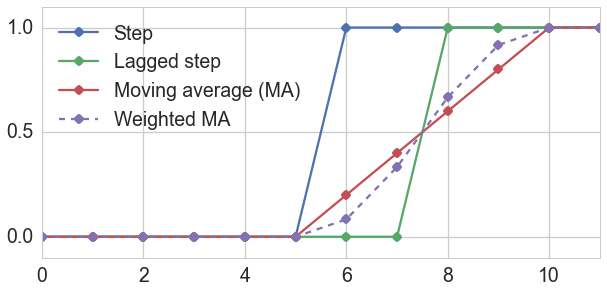

In [6]:
step = np.zeros(12)
lag_step = step.copy()
step[6:] = 1
lag_step[8:] = 1
rect_step = flm.causal_rect_window_filter(step, 5)
hann_step = flm.causal_hann_window_filter(step, 5)
step_labels = ['Step', 'Lagged step', 'Moving average (MA)', 'Weighted MA']
step_arrays = [step, lag_step, rect_step, hann_step]
step_dict = {key: value for key, value in zip(step_labels, step_arrays)}
df_step = pd.DataFrame(step_dict, columns=step_labels)
step_style = ['-o', '-o', '-o', '--o']
df_step.plot(style=step_style, yticks=[0, 0.5, 1], figsize=(10, 4.5))
plt.ylim([-0.1, 1.1]);

# Fit of Kenya data

This fit uses the optimal transition time under the constraint that all parameters undergo the same transition time. A full optimization is performed at the end of the notebook with independent transition times for all parameters, with little improvement in the $R^2$.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     107.3
Date:                Sun, 11 Oct 2015   Prob (F-statistic):           1.28e-28
Time:                        20:11:31   Log-Likelihood:                -313.84
No. Observations:                  73   AIC:                             637.7
Df Residuals:                      68   BIC:                             649.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         67.4292      4.998     13.491      0.0

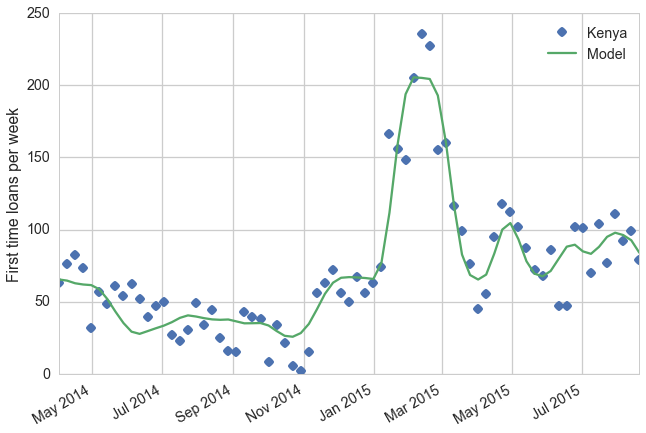

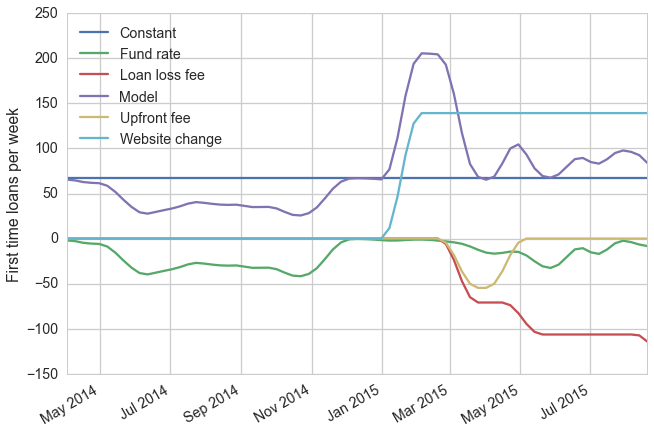

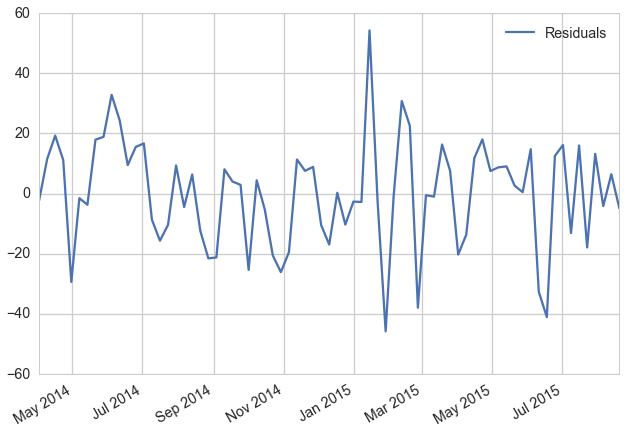

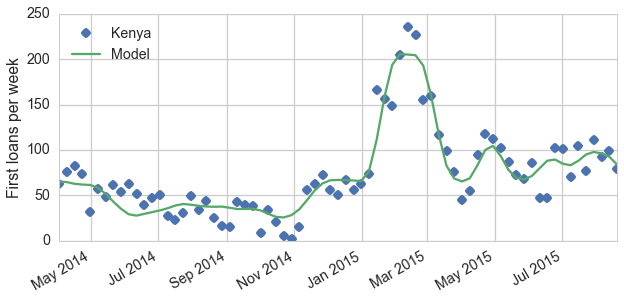

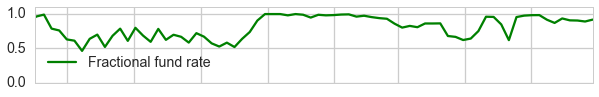

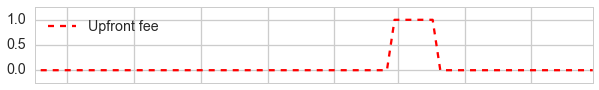

In [7]:
#Fit of Kenya

transition_time = round(4.0/weeks_per_bin)
lag = 0
web_lag = 0
# Funding only ends two weeks after the creation date of the loan, so we need a two week lag to compensate.
fund_lag = round(2.0 / weeks_per_bin)
filter_name = 'hann'

# fund rate
fund_rate = flm.LaggedParameter(df_fund_rate.Kenya.values - 1, 'Fund rate', transition_time, shift_size=fund_lag+lag, filter_type=filter_name)

# loan loss fee
loan_loss_fee = flm.LaggedParameter(df_loan_loss_fee_kenya.fee_level.values/df_max_first_loan.max_loan.values, 'Loan loss fee', transition_time, shift_size=lag, filter_type=filter_name)

# web change
web_change = flm.LaggedParameter(df_website_change.web_change.values, 'Website change', transition_time, shift_size=web_lag+lag, filter_type=filter_name)

# upfront fee
upfront_fee = flm.LaggedParameter(df_upfront_fee.upfront_fee.values, 'Upfront fee', transition_time, shift_size=lag, filter_type=filter_name)

# invite feature
max_invite = flm.LaggedParameter(df_total_borrowers.Kenya.values * df_max_invites.max_invites.values, 'Max invites', transition_time, shift_size=lag, filter_type=filter_name)

# max loan feature
max_loan = flm.LaggedParameter(df_max_first_loan.max_loan.values, 'Max loan', transition_time, shift_size=lag, filter_type=filter_name)

# output
dependent_array = df_first_loans_count.Kenya.values

start_date = np.datetime64('2014-04-01T00Z', 'ns')

list_lag_params = [loan_loss_fee, web_change, fund_rate, upfront_fee]

lag_model_kenya = flm.LagModel(list_lag_params, dependent_array, time_bins_center)
lag_model_kenya.fit(start_time=start_date)
lag_model_kenya.print_summary()

sns.set()
sns.set_context('talk', font_scale=1.1)
sns.set_style('whitegrid')

ws_width = 10
ws_height = 1.5

df_fit = lag_model_kenya.display_fit('Kenya', y_label='First time loans per week')

df_fit_none = df_fit.copy()

df_fit.plot(figsize=(ws_width, 3*ws_height), style=['o', '-'], legend=False)
plt.ylabel('First loans per week')
plt.legend(['Kenya', 'Model'], loc=2)

df_plot = df_fund_rate[['Kenya']].plot(figsize=(ws_width, ws_height), legend=False, ylim=(0, 1.1), yticks=([0,0.5,1]), style=['g'])
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
plt.legend(['Fractional fund rate'], loc=3)
df_plot.set_xticklabels([])

df_plot = df_upfront_fee.plot(figsize=(ws_width, ws_height), yticks=[0, 0.5, 1], legend=False, style=['--r'])
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
plt.ylim([-.25,1.25])
plt.legend(['Upfront fee'], loc=2)
df_plot.set_xticklabels([])

sns.set()
sns.set_context('talk', font_scale=1.5)
sns.set_style('whitegrid')

peak_start = np.datetime64('2015-01-01T00Z', 'ns')
peak_end = np.datetime64('2015-03-01T00Z', 'ns')
kenya_fit_scaled = lag_model_kenya.get_normalized_results(peak_start, peak_end)

# Fit of Ghana data

This uses the same transition time as for Kenya, which still optimizes $R^2$. It does not use the fund rate parameter as there are not enough data in 2014 to constrain it with.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     72.42
Date:                Sun, 11 Oct 2015   Prob (F-statistic):           2.82e-21
Time:                        20:23:41   Log-Likelihood:                -272.53
No. Observations:                  73   AIC:                             553.1
Df Residuals:                      69   BIC:                             562.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          5.2728      1.619      3.256      0.0

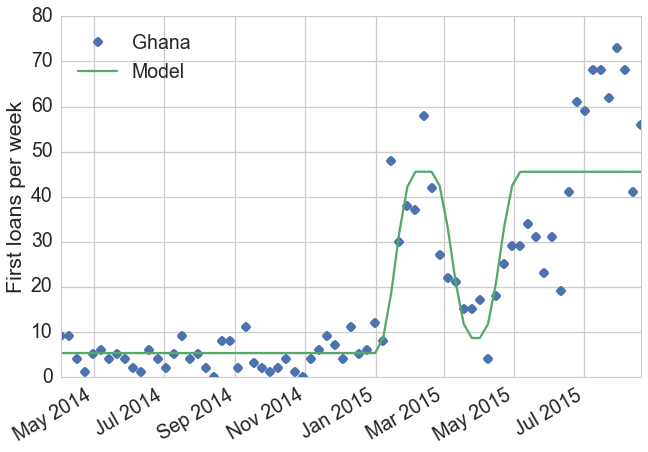

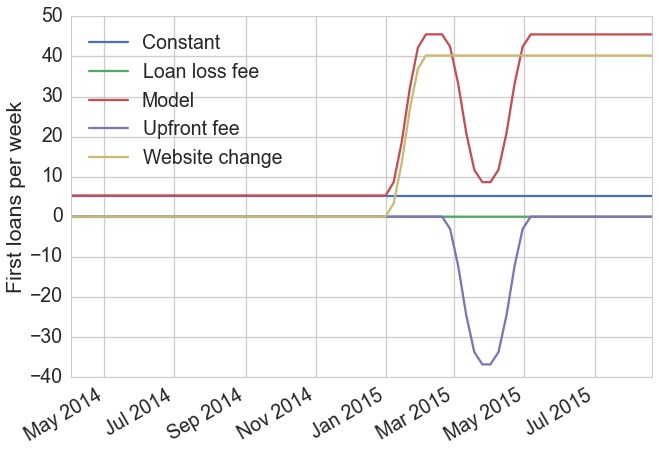

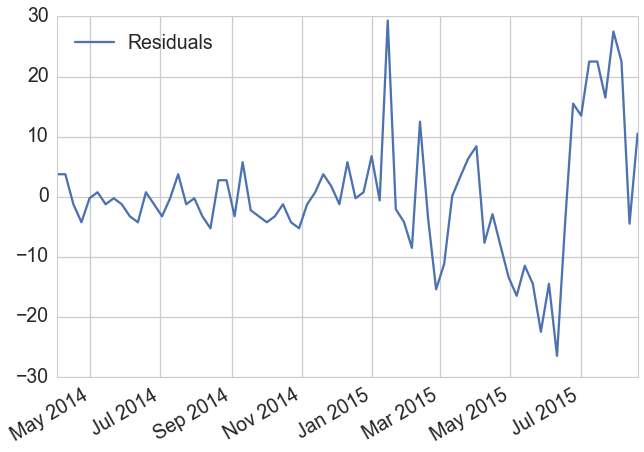

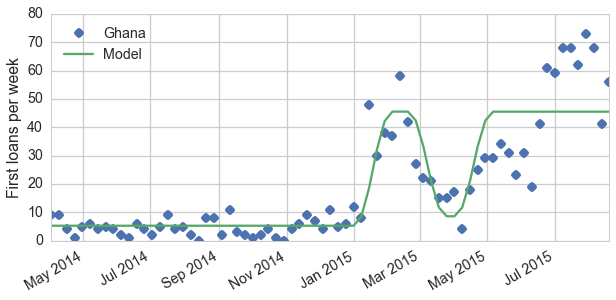

In [11]:
#Fit of Ghana, Lagged

transition_time = round(4.0/weeks_per_bin)
lag = 0
web_lag = 0
# Funding only ends two weeks after the creation date of the loan, so we need a two week lag to compensate.
fund_lag = round(2.0 / weeks_per_bin)
filter_name = 'hann'

# fund rate
fund_rate = flm.LaggedParameter(df_fund_rate.Ghana.values - 1, 'Fund rate', transition_time, shift_size=fund_lag+lag, filter_type=filter_name)

# loan loss fee
loan_loss_fee = flm.LaggedParameter(df_loan_loss_fee_ghana.fee_level.values/df_max_first_loan.max_loan.values, 'Loan loss fee', transition_time, shift_size=lag, filter_type=filter_name)

# web change
web_change = flm.LaggedParameter(df_website_change.web_change.values, 'Website change', transition_time, shift_size=web_lag+lag, filter_type=filter_name)

# upfront fee
upfront_fee = flm.LaggedParameter(df_upfront_fee.upfront_fee.values, 'Upfront fee', transition_time, shift_size=lag, filter_type=filter_name)

# output
dependent_array = df_first_loans_count.Ghana.values

start_date = np.datetime64('2014-04-01T00Z', 'ns')

list_lag_params = [loan_loss_fee, web_change, upfront_fee]

lag_model_ghana = flm.LagModel(list_lag_params, dependent_array, time_bins_center)
lag_model_ghana.fit(start_time=start_date)
lag_model_ghana.print_summary()
df_fit = lag_model_ghana.display_fit('Ghana', y_label='First loans per week')

sns.set()
sns.set_context('talk', font_scale=1.1)
sns.set_style('whitegrid')

ws_width = 10
ws_height = 1.5

df_fit.plot(figsize=(ws_width, 3*ws_height), style=['o', '-'], legend=False)
plt.ylabel('First loans per week')
plt.legend(['Ghana', 'Model'], loc=2)

sns.set()
sns.set_context('talk', font_scale=1.5)
sns.set_style('whitegrid')

peak_start = np.datetime64('2015-01-01T00Z', 'ns')
peak_end = np.datetime64('2015-03-01T00Z', 'ns')
ghana_fit_scaled = lag_model_ghana.get_normalized_results(peak_start, peak_end)

# Fit of Indonesia

This uses the same transition time as for Kenya, which still optimizes $R^2$. It does not use the fund rate parameter as there are not enough data in 2014 to constrain it with. In addition, a lag of two weeks is necessary to match the transition to the new website.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     85.91
Date:                Sun, 11 Oct 2015   Prob (F-statistic):           3.00e-23
Time:                        20:30:21   Log-Likelihood:                -216.46
No. Observations:                  73   AIC:                             440.9
Df Residuals:                      69   BIC:                             450.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.9452      0.734      2.650      0.0

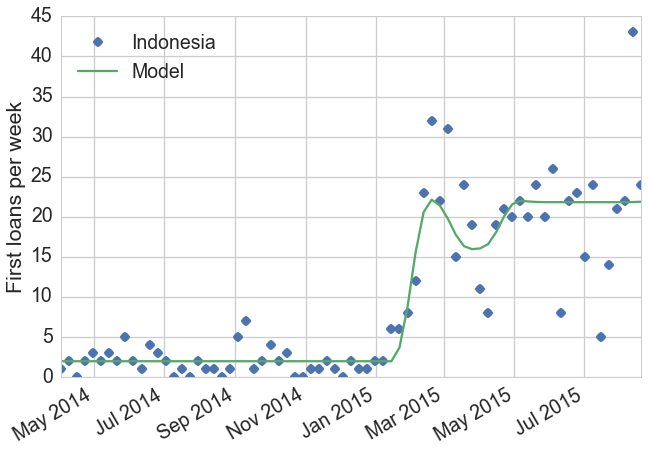

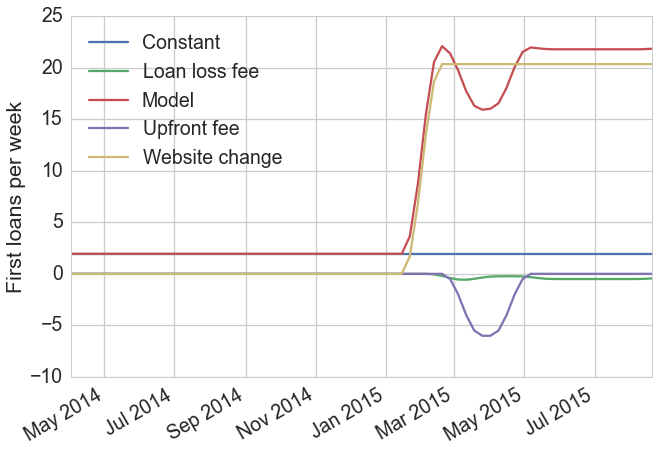

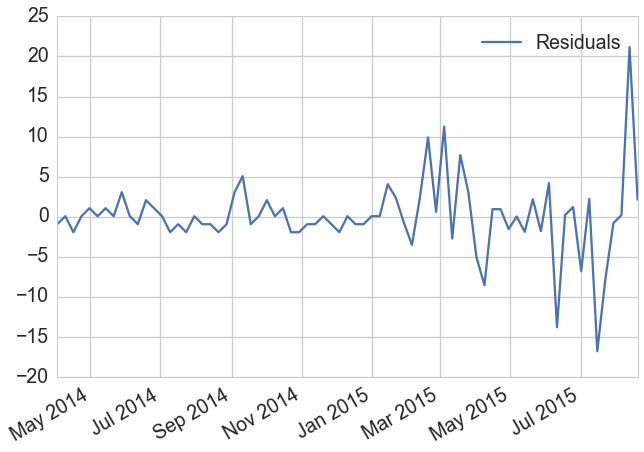

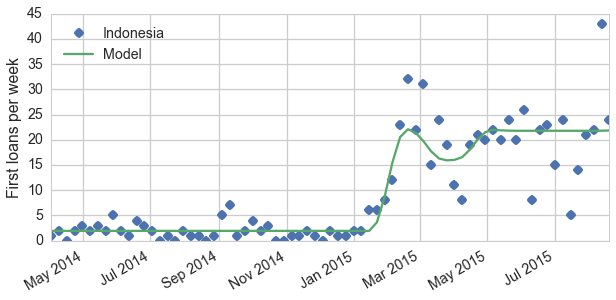

In [13]:
#Fit of Indonesia, Lagged

ransition_time = round(4.0/weeks_per_bin)
lag = 0
web_lag = round(2.0 / weeks_per_bin)
# Funding only ends two weeks after the creation date of the loan, so we need a two week lag to compensate.
fund_lag = round(2.0 / weeks_per_bin)
filter_name = 'hann'

# fund rate
fund_rate = flm.LaggedParameter(df_fund_rate.Indonesia.values - 1, 'Fund rate', transition_time, shift_size=fund_lag+lag, filter_type=filter_name)

# loan loss fee
loan_loss_fee = flm.LaggedParameter(df_loan_loss_fee_indonesia.fee_level.values/df_max_first_loan.max_loan.values, 'Loan loss fee', transition_time, shift_size=lag, filter_type=filter_name)

# web change
web_change = flm.LaggedParameter(df_website_change.web_change.values, 'Website change', transition_time, shift_size=web_lag+lag, filter_type=filter_name)

# upfront fee
upfront_fee = flm.LaggedParameter(df_upfront_fee.upfront_fee.values, 'Upfront fee', transition_time, shift_size=lag, filter_type=filter_name)

# output
dependent_array = df_first_loans_count.Indonesia.values

start_date = np.datetime64('2014-04-01T00Z', 'ns')

list_lag_params = [loan_loss_fee, web_change, upfront_fee]

lag_model_indonesia = flm.LagModel(list_lag_params, dependent_array, time_bins_center)
lag_model_indonesia.fit(start_time=start_date)
lag_model_indonesia.print_summary()
df_fit = lag_model_indonesia.display_fit('Indonesia', y_label='First loans per week')

sns.set()
sns.set_context('talk', font_scale=1.1)
sns.set_style('whitegrid')

ws_width = 10
ws_height = 1.5

df_fit.plot(figsize=(ws_width, 3*ws_height), style=['o', '-'], legend=False)
plt.ylabel('First loans per week')
plt.legend(['Indonesia', 'Model'], loc=2)

sns.set()
sns.set_context('talk', font_scale=1.5)
sns.set_style('whitegrid')

peak_start = np.datetime64('2015-01-01T00Z', 'ns')
peak_end = np.datetime64('2015-03-01T00Z', 'ns')
indonesia_fit_scaled = lag_model_indonesia.get_normalized_results(peak_start, peak_end)

# All countries scaled models

Models for all the countries scaled to the first loan rate at the peak of the website change.

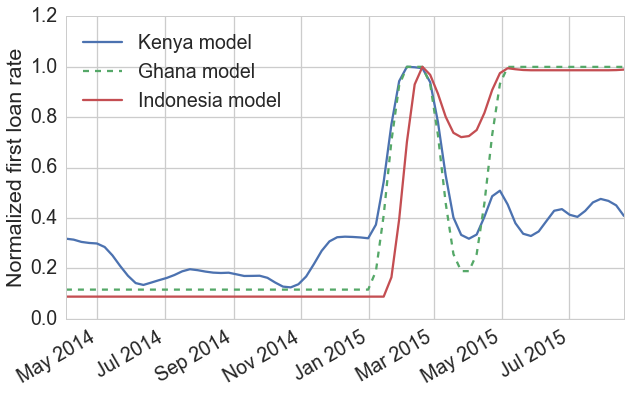

In [14]:
time_axis = lag_model_kenya.time_axis
df_scaled = pd.DataFrame({'Kenya model': kenya_fit_scaled,
                          'Ghana model': ghana_fit_scaled,
                          'Indonesia model': indonesia_fit_scaled},
                         columns=['Kenya model', 'Ghana model', 'Indonesia model'], index=time_axis)
fp = df_scaled.plot(style=['-', '--'], figsize=(10, 6))
plt.ylim([0,1.2])
#plt.setp(fp, linestyle='--')
#plt.Line2D.set_linestyle('--')
plt.ylabel('Normalized first loan rate')


# Optimization with consistent transition

Optimization with the same transition time for all parameters with different lag shifts and filter types. The rectangular filter generates marginally higher $R^2$ values compared to the Hann filter, but its less realistic transition profile is not perferred.

In [15]:
list_transition = [1, 2, 3, 4, 5, 6, 7, 8]
list_lag = [0, 1, 2, 3]
list_web_lag = [0, 1, 2, 3]
list_fund_lag = [0, 1, 2, 3, 4]
list_filter = ['none', 'rect', 'hann']

def fit_kenya(transition_time, lag, web_lag, fund_lag, filter_name):

    # fund rate
    fund_rate = flm.LaggedParameter(df_fund_rate.Kenya.values - 1, 'Fund rate', transition_time, shift_size=fund_lag+lag, filter_type=filter_name)

    # loan loss fee
    loan_loss_fee = flm.LaggedParameter(df_loan_loss_fee_kenya.fee_level.values/df_max_first_loan.max_loan.values, 'Loan loss fee', transition_time, shift_size=lag, filter_type=filter_name)

    # web change
    web_change = flm.LaggedParameter(df_website_change.web_change.values, 'Website change', transition_time, shift_size=web_lag+lag, filter_type=filter_name)

    # upfront fee
    upfront_fee = flm.LaggedParameter(df_upfront_fee.upfront_fee.values, 'Upfront fee', transition_time, shift_size=lag, filter_type=filter_name)

    # output
    dependent_array = df_first_loans_count.Kenya.values

    start_date = np.datetime64('2014-04-01T00Z', 'ns')

    list_lag_params = [loan_loss_fee, web_change, fund_rate, upfront_fee]

    lag_model_kenya = flm.LagModel(list_lag_params, dependent_array, time_bins_center)
    lag_model_kenya.fit(start_time=start_date)
    return lag_model_kenya.results.rsquared

all_comb = it.product(list_transition, list_lag, list_web_lag, list_fund_lag, list_filter)
comb_labels = ['Transition', 'Lag', 'Web lag', 'Fund lag', 'Filter', 'R2']
dict_comb = {label: [] for label in comb_labels}
df_comb = pd.DataFrame(dict_comb, columns=comb_labels)
for index, comb in enumerate(all_comb):
    list_comb = list(comb)
    r2 = fit_kenya(*comb)
    list_comb.append(r2)
    df_comb.loc[index] = list_comb


In [16]:
df_comb.sort(columns='R2', ascending=False)

,Transition,Lag,Web lag,Fund lag,Filter,R2
730,4,0,0,3,rect,0.882560
733,4,0,0,4,rect,0.881243
727,4,0,0,2,rect,0.881113
508,3,0,1,4,rect,0.874324
967,5,0,0,2,rect,0.874001
970,5,0,0,3,rect,0.872335
745,4,0,1,3,rect,0.871755
505,3,0,1,3,rect,0.871722
731,4,0,0,3,hann,0.871105
964,5,0,0,1,rect,0.870585


# Optimization with variable transition

Optimization with different transition times for each parameters with different lag shifts and filter types. The multiple transition times generate marginally higher $R^2$ values compared to the single transition time, but its lack of simplicity is not perferred.

In [19]:
list_transition = [2, 3, 4, 5, 6, 7, 8]
list_lag = [0]
list_web_lag = [0, 1]
list_fund_lag = [0, 1, 2, 3, 4]
list_filter = ['rect', 'hann']

def fit_kenya(transition_time_fund, transition_time_fee, transition_time_web, transition_time_up, lag, web_lag, fund_lag, filter_name):

    # fund rate
    fund_rate = flm.LaggedParameter(df_fund_rate.Kenya.values - 1, 'Fund rate', transition_time_fund, shift_size=fund_lag+lag, filter_type=filter_name)

    # loan loss fee
    loan_loss_fee = flm.LaggedParameter(df_loan_loss_fee_kenya.fee_level.values/df_max_first_loan.max_loan.values, 'Loan loss fee', transition_time_fee, shift_size=lag, filter_type=filter_name)

    # web change
    web_change = flm.LaggedParameter(df_website_change.web_change.values, 'Website change', transition_time_web, shift_size=web_lag+lag, filter_type=filter_name)

    # upfront fee
    upfront_fee = flm.LaggedParameter(df_upfront_fee.upfront_fee.values, 'Upfront fee', transition_time_up, shift_size=lag, filter_type=filter_name)

    # output
    dependent_array = df_first_loans_count.Kenya.values

    start_date = np.datetime64('2014-04-01T00Z', 'ns')

    list_lag_params = [loan_loss_fee, web_change, fund_rate, upfront_fee]

    lag_model_kenya = flm.LagModel(list_lag_params, dependent_array, time_bins_center)
    lag_model_kenya.fit(start_time=start_date)
    return lag_model_kenya.results.rsquared

all_comb = it.product(list_transition, list_transition, list_transition, list_transition, list_lag, list_web_lag, list_fund_lag, list_filter)
comb_labels = ['Transition fund', 'Transition fee', 'Transition web', 'Transition up', 'Lag', 'Web lag', 'Fund lag', 'Filter', 'R2']
dict_comb = {label: [] for label in comb_labels}
df_comb = pd.DataFrame(dict_comb, columns=comb_labels)
for index, comb in enumerate(all_comb):
    list_comb = list(comb)
    r2 = fit_kenya(*comb)
    list_comb.append(r2)
    df_comb.loc[index] = list_comb


In [20]:
df_comb.sort(columns='R2', ascending=False)

,Transition fund,Transition fee,Transition web,Transition up,Lag,Web lag,Fund lag,Filter,R2
3368,2,5,5,2,0,0,4,rect,0.896141
4348,2,6,5,2,0,0,4,rect,0.895531
3388,2,5,5,3,0,0,4,rect,0.894236
44522,8,5,5,2,0,0,1,rect,0.894195
45502,8,6,5,2,0,0,1,rect,0.893970
44542,8,5,5,3,0,0,1,rect,0.893627
37662,7,5,5,2,0,0,1,rect,0.893612
38642,7,6,5,2,0,0,1,rect,0.893574
5328,2,7,5,2,0,0,4,rect,0.893500
24924,5,6,5,2,0,0,2,rect,0.893472
